# **This is the time series model for the stock prediction dataset**

In [ ]:
!pip install plotly --upgrade

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [23]:
filepath = '/content/AABA_2006-01-01_to_2018-01-01.csv'
stock = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
print(stock.shape)  # (123, 8)
stock.tail()

(3019, 6)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA
2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA


In [28]:
def visualuze_multivariate_time_series(data,rows:int=3,cols:int=2):
  fig, axes = plt.subplots(nrows=rows, ncols=cols, dpi=120, figsize=(10,6))
  # i will simply give the column count/index
  for i, ax in enumerate(axes.flatten()):
    df = data[data.columns[i]]
    ax.plot(df, color='red', linewidth=1)
    fig.tight_layout(pad=3.0)#this is for providing proper spacing between the plots
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [26]:
stock.drop('Name',inplace=True,axis=1)

IndexError: ignored

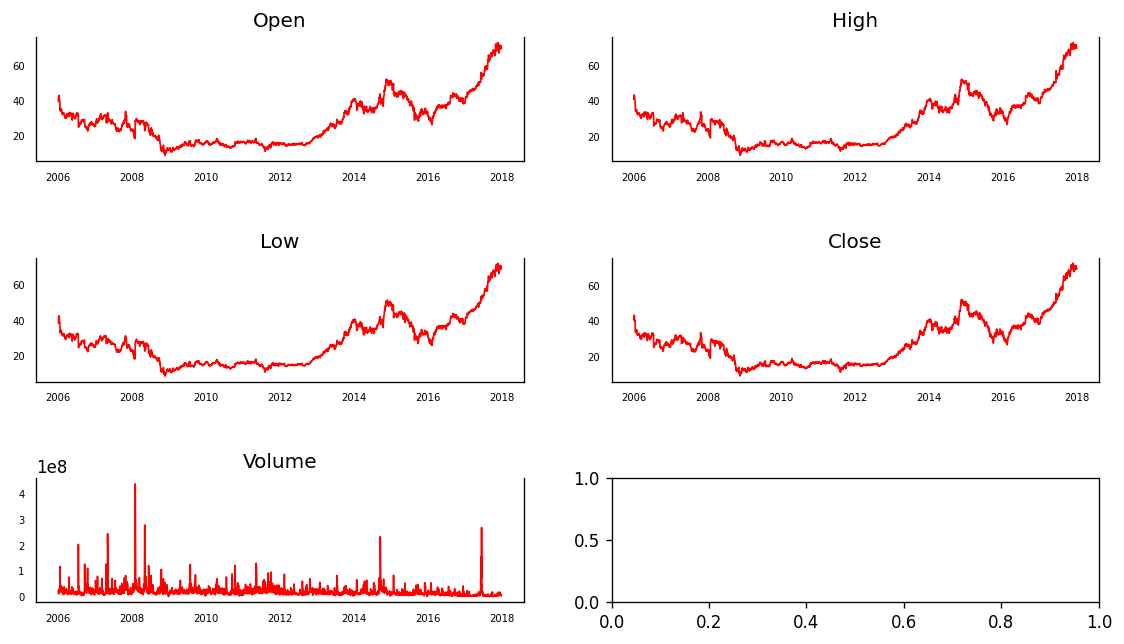

In [29]:
visualuze_multivariate_time_series(stock)

In [30]:
def grangers_causation_matrix(data, variables,maxlag:int=12, test:str='ssr_chi2test', verbose:bool=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    from statsmodels.tsa.stattools import grangercausalitytests
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


#how to read this table?
'''
If a given p-value is < significance level (0.05), 
then, the corresponding X time series (column) causes/effects the Y time series (row).
'''


'\nIf a given p-value is < significance level (0.05), \nthen, the corresponding X time series (column) causes/effects the Y time series (row).\n'

In [31]:
grangers_causation_matrix(stock, variables = stock.columns)

,Open_x,High_x,Low_x,Close_x,Volume_x
Open_y,1.0000,0.0000,0.0000,0.0,0.0003
High_y,0.0000,1.0000,0.0000,0.0,0.0000
Low_y,0.0000,0.0000,1.0000,0.0,0.0005
Close_y,0.0003,0.0258,0.0012,1.0,0.5020
Volume_y,0.0000,0.0000,0.0000,0.0,1.0000


In [32]:
def cointegration_test(df, alpha=0.05):
  from statsmodels.tsa.vector_ar.vecm import coint_johansen 
  """Perform Johanson's Cointegration Test and Report Summary"""
  out = coint_johansen(df,-1,5)
  d = {'0.90':0, '0.95':1, '0.99':2}
  traces = out.lr1
  cvts = out.cvt[:, d[str(1-alpha)]]
  def adjust(val, length= 6): return str(val).ljust(length)
  # Summary
  print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
  for col, trace, cvt in zip(df.columns, traces, cvts):
    print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [33]:
cointegration_test(stock)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   ::  1320.68   > 60.0627   =>   True
High   ::  805.78    > 40.1749   =>   True
Low    ::  313.91    > 24.2761   =>   True
Close  ::  103.22    > 12.3212   =>   True
Volume ::  1.2       > 4.1296    =>   False


In [36]:
#splitting the dataset into train and test set
nobs = 500 #this is the numbe of elements that will be contained in the test set
stock_train, stock_test = stock[0:-nobs], stock[-nobs:]

# Check size
print(stock_train.shape)  # (119, 8)
print(stock_test.shape)  # (4, 8)

(2519, 5)
(500, 5)


In [37]:
#checking for stationarity and making the time series stationary
#implementing ADFuller test with significance/threshold value of 0.5
def adfuller_test(series, signif=0.05, name='', verbose=False):
  from statsmodels.tsa.stattools import adfuller
  """Perform ADFuller to test for Stationarity of given series and print report"""
  r = adfuller(series, autolag='AIC')
  output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
  p_value = output['pvalue'] 
  def adjust(val, length= 6): return str(val).ljust(length)
  # Print Summary
  print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
  print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
  print(f' Significance Level    = {signif}')
  print(f' Test Statistic        = {output["test_statistic"]}')
  print(f' No. Lags Chosen       = {output["n_lags"]}')
  for key,val in r[4].items():
    print(f' Critical value {adjust(key)} = {round(val, 3)}')
  
  if p_value <= signif:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    print(f" => Series is Stationary.")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    print(f" => Series is Non-Stationary.")    

In [38]:
#implementing ADFuller test on each column
for name, column in stock_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9407
 No. Lags Chosen       = 3
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.3131. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8085
 No. Lags Chosen       = 7
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.3762. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit roo

In [39]:
#since none of the time series is stationaty therefore differencing all of them
stock_differenced = stock_train.diff().dropna()
#AD Fuller test on each of the tim series
for name, column in stock_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -31.0573
 No. Lags Chosen       = 2
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.8525
 No. Lags Chosen       = 6
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [41]:
#All the time series are stationary now we can proceed
#How to select the right order P of the var model
def check_lag(data):
  from statsmodels.tsa.api import VAR
  model = VAR(data)
  for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


In [42]:
# we select the model and one of the criteria is BIC the value in inversely proportional to the performance of the model
check_lag(stock_differenced)

Lag Order = 1
AIC :  24.702563017852352
BIC :  24.772060312192465
FPE :  53479437063.12179
HQIC:  24.727785130186437 

Lag Order = 2
AIC :  24.232255385921004
BIC :  24.359709046087985
FPE :  33414496325.42305
HQIC:  24.27851208514321 

Lag Order = 3
AIC :  23.954951050973012
BIC :  24.140399260357785
FPE :  25322316254.027702
HQIC:  24.02225704518545 

Lag Order = 4
AIC :  23.80219196256597
BIC :  24.045672945406373
FPE :  21735091376.67567
HQIC:  23.890561976063157 

Lag Order = 5
AIC :  23.70467878778624
BIC :  24.006230809227013
FPE :  19715727011.997936
HQIC:  23.8141275610793 

Lag Order = 6
AIC :  23.6251816081319
BIC :  23.984842974284827
FPE :  18209110331.856815
HQIC:  23.75572389797286 

Lag Order = 7
AIC :  23.56967594170449
BIC :  23.987484999708617
FPE :  17226001010.256496
HQIC:  23.721326521110587 

Lag Order = 8
AIC :  23.53198615153933
BIC :  24.00798128962132
FPE :  16588917385.660633
HQIC:  23.704759809817386 

Lag Order = 9
AIC :  23.504394837130505
BIC :  24.03861

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [44]:
#based on the above function the lag order is 6
#or we can use this function
def check_lag_auto(data,maxlags:int=12):
  from statsmodels.tsa.api import VAR
  model = VAR(stock_differenced)
  x = model.select_order(maxlags=12)
  display(x.summary())

check_lag_auto(stock_differenced)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,25.88,25.89,1.741e+11,25.89
1,24.61,24.68,4.897e+10,24.64
2,24.14,24.27,3.040e+10,24.18
3,23.87,24.06,2.327e+10,23.94
4,23.72,23.96,2.004e+10,23.81
5,23.63,23.93,1.821e+10,23.73
6,23.55,23.91*,1.684e+10,23.68
7,23.49,23.91,1.590e+10,23.64
8,23.45,23.93,1.533e+10,23.63
9,23.43,23.96,1.491e+10,23.62*


In [45]:
#going with lag order 6
#selecting the lag 4 since it is giving the best results
def train_model(data,lag:int):
  from statsmodels.tsa.api import VAR
  model = VAR(data)
  model_fitted = model.fit(lag)
  return model_fitted

In [47]:
var_model = train_model(stock_differenced,6)
var_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 17, Jan, 2022
Time:                     10:23:29
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    23.9848
Nobs:                     2512.00    HQIC:                   23.7557
Log likelihood:          -47340.1    FPE:                1.82091e+10
AIC:                      23.6252    Det(Omega_mle):     1.71260e+10
--------------------------------------------------------------------
Results for equation Open
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.002246         0.009077           -0.247           0.805
L1.Open          -0.955790         0.040933          -23.350           0.000
L1.High          -0.024972         0.049623           -0.503           0.615


In [48]:
'''
The value of this statistic can vary between 0 and 4.
 The closer it is to the value 2, then there is no 
 significant serial correlation. 
 The closer to 0, there is a positive serial correlation,
  and the closer it is to 4 implies negative serial correlation.
'''
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(var_model.resid)

for col, val in zip(stock.columns, out):
    print(col, ':', round(val, 2))

Open : 2.01
High : 2.0
Low : 1.99
Close : 1.99
Volume : 2.02


In [49]:
#forecasting using varModel
# Get the lag order
lag_order = var_model.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = stock_differenced.values[-lag_order:]
forecast_input

6


array([[-2.7000000e-01,  2.6000000e-01,  2.5000000e-01,  4.4000000e-01,
         1.6011370e+06],
       [ 2.2000000e-01, -1.3000000e-01, -2.5000000e-01, -6.7000000e-01,
        -6.6882580e+06],
       [-6.3000000e-01, -3.6000000e-01, -1.7000000e-01, -1.1000000e-01,
         1.4896370e+06],
       [-1.1000000e+00, -1.3300000e+00, -2.0400000e+00, -1.8600000e+00,
         1.7752884e+07],
       [-5.7000000e-01, -3.0000000e-02,  3.9000000e-01,  8.0000000e-01,
        -1.0875079e+07],
       [ 1.2000000e-01,  1.4000000e-01,  7.0000000e-02, -4.0000000e-02,
         1.7466810e+06]])

In [50]:
#forecast
fc = var_model.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=stock.index[-nobs:], columns=stock.columns + '_2d')
df_forecast

,Open_2d,High_2d,Low_2d,Close_2d,Volume_2d
Date,,,,,
2016-01-07,0.409899,0.145308,0.278207,0.116924,-2.592111e+06
2016-01-08,0.060908,0.063753,0.087369,0.044000,1.164140e+06
2016-01-11,-0.012750,0.033956,-0.017494,0.020116,-3.250381e+06
2016-01-12,-0.136587,-0.101147,-0.094747,-0.076438,1.175578e+06
2016-01-13,0.126846,0.044386,-0.025525,-0.039114,2.636992e+06
...,...,...,...,...,...
2017-12-22,-0.003884,-0.003844,-0.003800,-0.003830,-2.923294e+03
2017-12-26,-0.003884,-0.003844,-0.003800,-0.003830,-2.923294e+03
2017-12-27,-0.003884,-0.003844,-0.003800,-0.003830,-2.923294e+03


In [51]:
#invert the transformation to get the real data
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [53]:
df_results = invert_transformation(stock_train, df_forecast, second_diff=True)        

In [54]:
df_results.columns

Index(['Open_2d', 'High_2d', 'Low_2d', 'Close_2d', 'Volume_2d', 'Open_1d',
       'Open_forecast', 'High_1d', 'High_forecast', 'Low_1d', 'Low_forecast',
       'Close_1d', 'Close_forecast', 'Volume_1d', 'Volume_forecast'],
      dtype='object')

In [55]:
df_results.loc[:, ['Open_forecast', 'High_forecast', 'Low_forecast', 'Close_forecast',
                   'Volume_forecast',]]

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Volume_forecast
Date,,,,,
2016-01-07,32.199899,32.745308,31.948207,32.236924,1.520233e+07
2016-01-08,32.790707,33.094370,32.383783,32.357848,1.552104e+07
2016-01-11,33.368764,33.477387,32.801865,32.498889,1.258937e+07
2016-01-12,33.810235,33.759257,33.125201,32.563491,1.083328e+07
2016-01-13,34.378552,34.085513,33.423011,32.588980,1.171418e+07
...,...,...,...,...,...
2017-12-22,-199.244715,-287.374873,-275.309167,-403.792968,-5.145995e+08
2017-12-26,-200.675905,-288.975115,-276.872652,-405.623875,-5.163918e+08
2017-12-27,-202.110980,-290.579202,-278.439936,-407.458612,-5.181869e+08


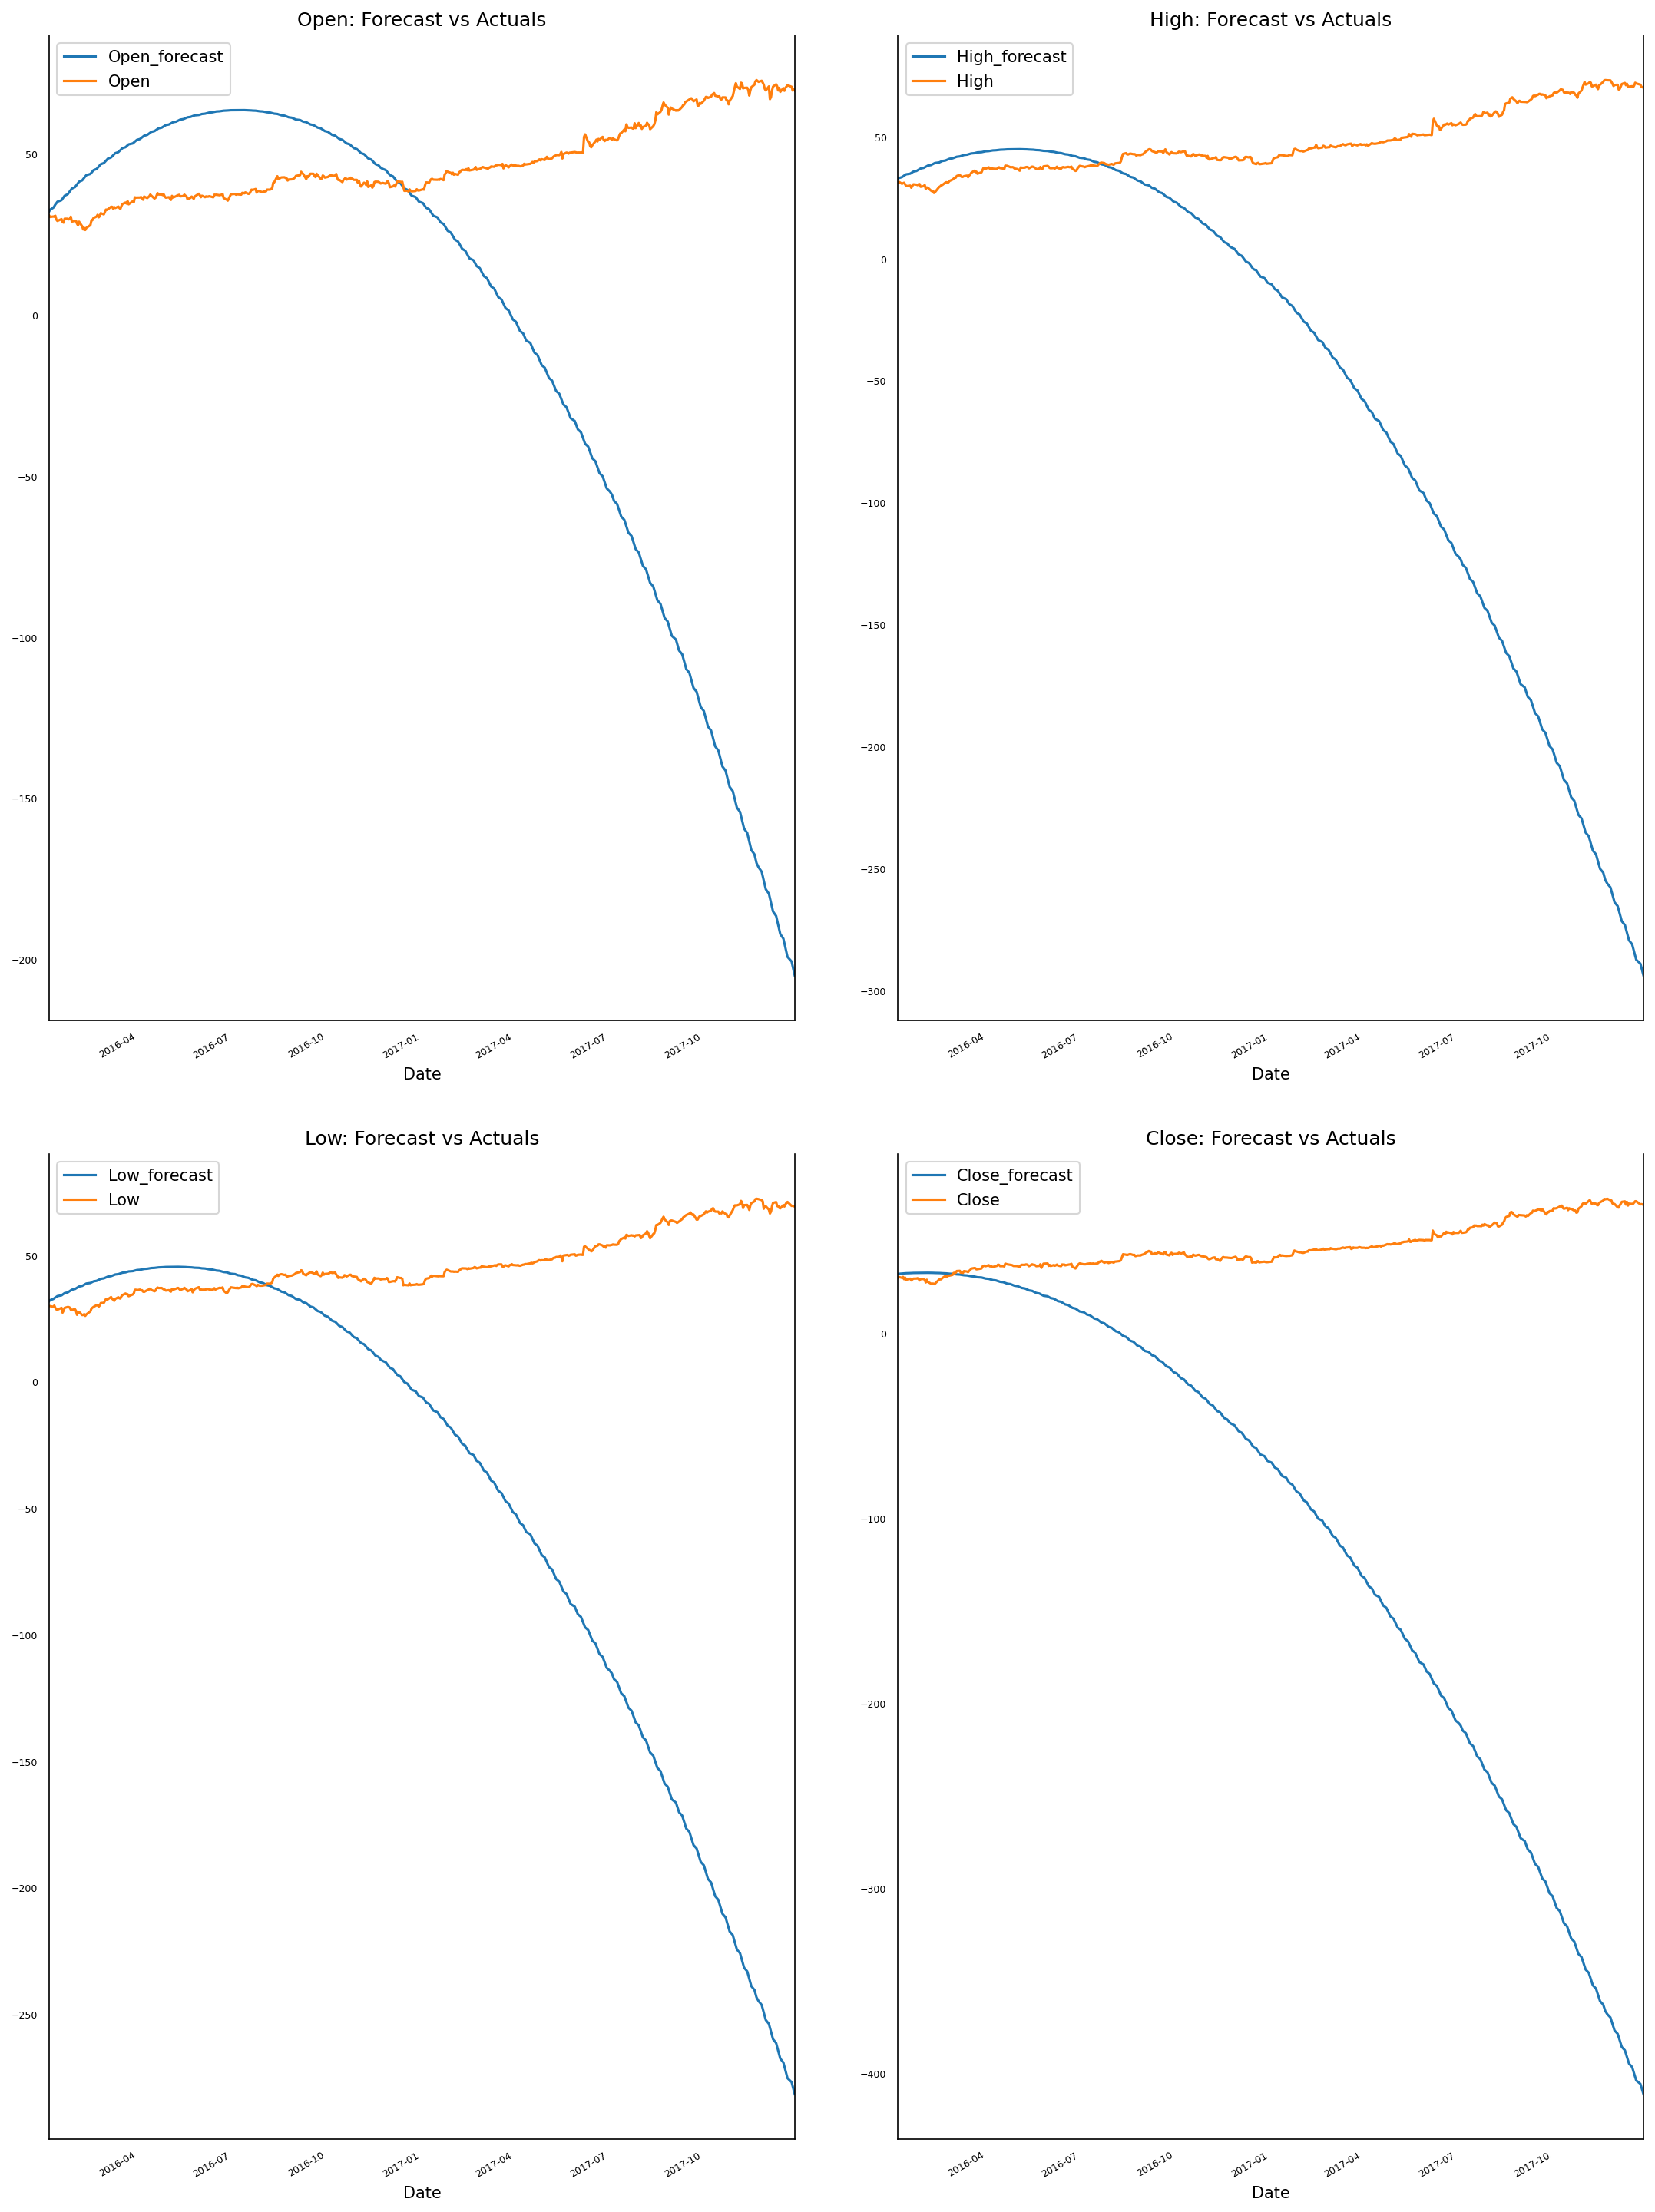

In [56]:
#Plotting forecast vs actual data
fig, axes = plt.subplots(nrows=int(len(stock.columns)/2), ncols=2, dpi=150, figsize=(15,20))
for i, (col,ax) in enumerate(zip(stock.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    stock_test[col][-nobs:].plot(legend=True, ax=ax);
    fig.tight_layout(pad=3.0)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

In [ ]:
#the results do not match at all?
#since this is a volatile dataset therfore we need to use ARCH or GARCH model for predicting the stock price.